<a href="https://colab.research.google.com/github/irajamuller/quantum_computing/blob/main/Algoritmo_de_Bernstein_Vazirani_e_Simon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit --quiet
!pip install qiskit-aer --quiet
!pip install pylatexenc --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 109.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex

import qiskit.quantum_info as qi
import numpy as np
import random as rd


# ALGORITMO DE BERNSTEIN-VAZIRANI

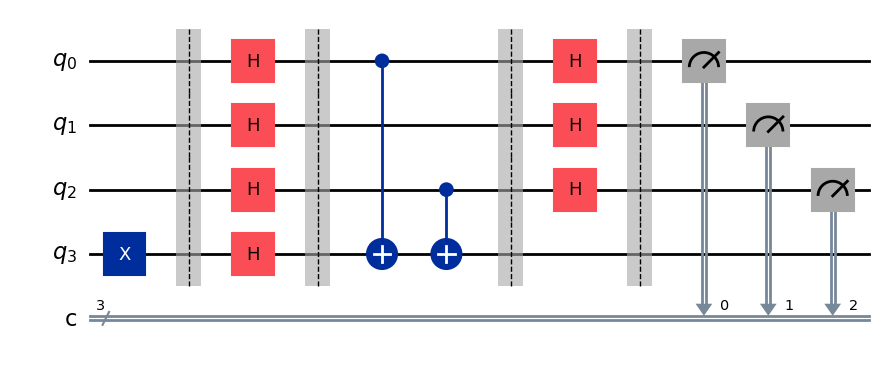

In [ ]:
# String secreta
s = '101'
n = len(s)

# Circuito: n qubits de entrada + 1 ancilla
qc = QuantumCircuit(n + 1, n)
# Inicializa o qubit ancilla em |1>
qc.x(n)
qc.barrier()
qc.h(range(n + 1))
qc.barrier()

# Oráculo BV para s = 101
for i, bit in enumerate(s):
    if bit == '1':
        qc.cx(i, n)
qc.barrier()
# Hadamard nos qubits de entrada novamente
qc.h(range(n))
qc.barrier()

# Medição dos qubits de entrada
qc.measure(range(n), range(n))

qc.draw('mpl')

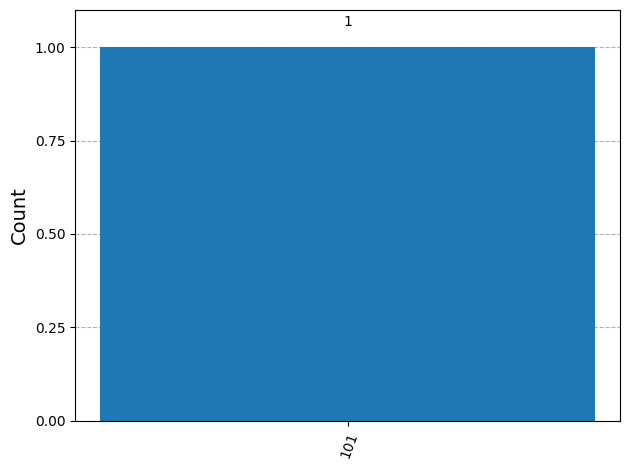

In [ ]:
qc_t = transpile(qc)
backend = AerSimulator()

result = backend.run(qc_t, shots=1).result()
counts = result.get_counts()
# Cuidado ao mudar a string s, pois o qiskit utiliza o primeiro qubit do circuito com o menos significativo
plot_histogram(counts)

# ALGORITMO DE SIMON

In [ ]:
def oracle_simon(qc, x, y):
    # A função f(x) da tabela é:
    # f(00)=10, f(01)=00, f(10)=00, f(11)=10

    # Caso x=11: Aplica CNOT de (q_1, q_0) para q_3
    # Qiskit usa ordem little-endian, então q[1] é o bit mais significativo (x1).
    qc.ccx(x[1], x[0], y[1])

    # Caso x=00: Aplica CNOT de (NOT q_1, NOT q_0) para q_3
    # 1a. Inverte os controles
    qc.x(x[0])
    qc.x(x[1])
    # 1b. Aplica CNOT
    qc.ccx(x[1], x[0], y[1])
    # 1c. Reverte os controles
    qc.x(x[0])
    qc.x(x[1])

    # 2. Implementa a saída q_2 = f_0(x) (o bit menos significativo de f(x))
    # q_2 nunca é flipado (f_0(x) é sempre 0)
    # Não precisamos de portas para q_2

    return qc

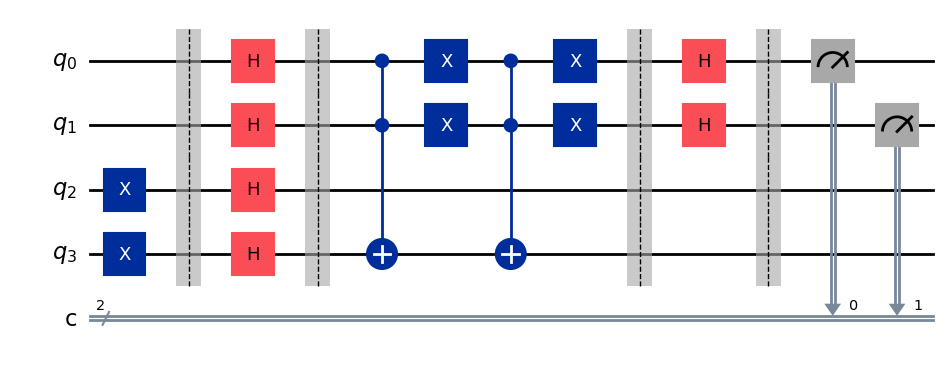

In [ ]:
# 4 Qubits: x (q[0], q[1]) e y (q[2], q[3])
q = QuantumRegister(4, 'q')
c = ClassicalRegister(2, 'c')
qc = QuantumCircuit(q, c)

# 1. Inicialização
x = [q[0], q[1]]  # x0, x1
y = [q[2], q[3]] # y0, y1

# 2. Configurar o registro de saída no estado |->
# Qubit de saída em |1> (para o caso Deutsch-Jozsa/Simon)
qc.x(y)
qc.barrier()

# 3. Aplicar Hadamard em todos os qubits
qc.h(q)
qc.barrier()

# 4. Aplicação do Oráculo Uf
oracle_simon(qc, x, y)
qc.barrier()

# 5. Aplicar Hadamard apenas ao registro de entrada
qc.h(x)
qc.barrier()

# 6. Medição
# Medimos apenas o registro de entrada (|z>)
qc.measure(x, c)

qc.draw('mpl')


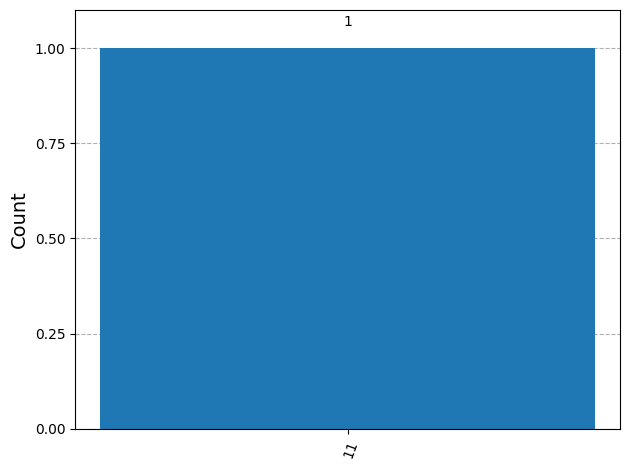

In [ ]:
qc_t = transpile(qc)
backend = AerSimulator()

result = backend.run(qc_t, shots=1).result()
counts = result.get_counts()
# Cuidado ao mudar a string s, pois o qiskit utiliza o primeiro qubit do circuito com o menos significativo
plot_histogram(counts)

# Após a coleta, precisará ser verificado o z.s = 0 (módulo 2), tanto para z = 00 como z = 11